In [70]:
import numpy as np

# For loadmat, which imports data from Matlab files and stores them in memory as
#  scipy tensors.
import scipy.io as sio

# For graphing
import matplotlib.pyplot as plt

# For filtering
from scipy.signal import butter, sosfiltfilt, find_peaks

In [71]:
def create_filter_500_to_5k(sample_frequency):
    """
    Returns a discrete time filter coefficients in sos format
    :param sample_frequency: sampling frequency of data
    :return: sos, G
    """

    order = 1  # order, for bandpass filter the effective order is doubled
    lower_cutoff_frequency = 500  # cutoff frequency 1
    upper_cutoff_frequency = 5000  # cutoff frequency 2

    # Design the Butterworth filter
    sos_filter_array = butter(
        order,
        [lower_cutoff_frequency, upper_cutoff_frequency],
        btype="bandpass",
        fs=sample_frequency,
        output="sos",
    )
    print("SOS FILTER ARRAY: ", sos_filter_array)
    return sos_filter_array

In [72]:
# Load data from .mat file
data_path = "./ECoGData.mat"
data = sio.loadmat(data_path)

# Create some references to the data so the user doesn't need to copy/paste this indexing elsewhere.
# This first one appears as data.Signal in the Matlab structure. e.g. ECOG_DATA[0] is
#  data.Signal{1, 1}
ECOG_DATA = data["data"]["Signal"][0][0][0]
STIM_TIMES = data["data"]["StimTimes"][0][0][0]
SAMPLE_FREQUENCY = data["data"]["SamplingFreq"][0][0][0][0]

#  Data Exploration
print("Signal: " + str(ECOG_DATA.shape))  # Three stim conditions
print("Stim Times: " + str(STIM_TIMES.shape))  # in seconds!
print("Sample Freq: ", SAMPLE_FREQUENCY)  # 24414 Hz

print("Final stim time: ", STIM_TIMES[0][-1][0])
print("approximate index of final stim: ", SAMPLE_FREQUENCY * (STIM_TIMES[0][-1][0]))
print("data set size: ", len(ECOG_DATA[0]))
print("Seconds in Data set #1: ", len(ECOG_DATA[0]) / SAMPLE_FREQUENCY)

Signal: (3,)
Stim Times: (3,)
Sample Freq:  24414.0625
Final stim time:  247.45099258422852
approximate index of final stim:  6041283.9986383915
data set size:  6325534
Seconds in Data set #1:  259.09387264


In [73]:
sos_filter = create_filter_500_to_5k(SAMPLE_FREQUENCY)

filtered_data_condition_1 = sosfiltfilt(sos_filter, ECOG_DATA[0].flatten())
filtered_data_condition_2 = sosfiltfilt(sos_filter, ECOG_DATA[1].flatten())
filtered_data_condition_3 = sosfiltfilt(sos_filter, ECOG_DATA[2].flatten())

sigma_condition_1 = np.median(np.abs(filtered_data_condition_1) / 0.6745)
sigma_condition_2 = np.median(np.abs(filtered_data_condition_2) / 0.6745)
sigma_condition_3 = np.median(np.abs(filtered_data_condition_3) / 0.6745)

threshold_condition_1 = 3 * sigma_condition_1
threshold_condition_2 = 3 * sigma_condition_2
threshold_condition_3 = 3 * sigma_condition_3

SOS FILTER ARRAY:  [[ 0.39534053  0.         -0.39534053  1.         -1.09785652  0.20931893]]


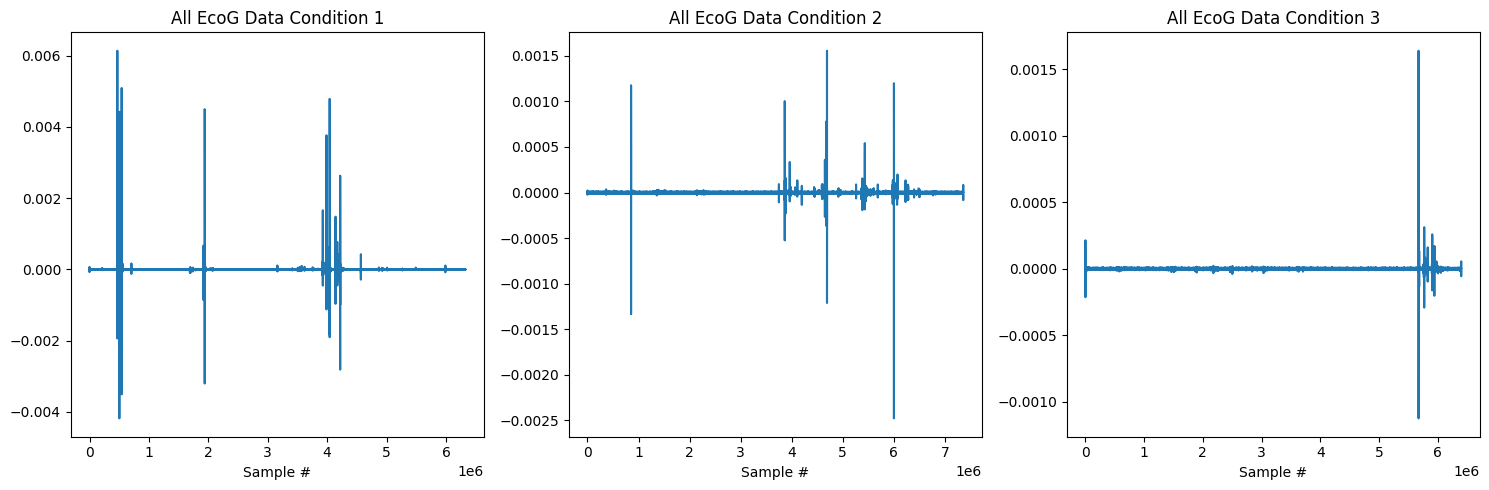

In [74]:
# Data exploration

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(filtered_data_condition_1, label="ECOG 1")
axs[0].set_title("All EcoG Data Condition 1")
axs[0].set_xlabel("Sample #")

axs[1].plot(filtered_data_condition_2, label="ECOG 2")
axs[1].set_title("All EcoG Data Condition 2")
axs[1].set_xlabel("Sample #")

axs[2].plot(filtered_data_condition_3, label="ECOG 3")
axs[2].set_title("All EcoG Data Condition 3")
axs[2].set_xlabel("Sample #")

plt.tight_layout()
plt.show()

In [75]:

def trial_runner(filtered_data, stimulation_start_times, threshold):

    trials = [
        {
            "trial_number": None,
            "time_window": [None, None],  # in seconds
            "ecog_data_index_window": [None, None],
            "spike_indices": [],
            "spike_times": [],
            "spike_rates": [],
        }
        for _ in range(50)
    ]

    for i, start_time in enumerate(stimulation_start_times):
        # Assign Trial Number
        trials[i]["trial_number"] = i + 1

        # Assign Trial Time Window
        trials[i]["time_window"] = [start_time[0] - 0.5, start_time[0] + 1.5]

        # Assign Trial Ecog index Window
        start_ecog_index = int(trials[i]["time_window"][0] * SAMPLE_FREQUENCY)
        end_ecog_index = int(trials[i]["time_window"][1] * SAMPLE_FREQUENCY)
        trials[i]["ecog_data_index_window"] = [start_ecog_index, end_ecog_index]

        # Find peaks in the window
        peaks, _ = find_peaks(
            filtered_data[start_ecog_index:end_ecog_index], height=threshold
        )
        trials[i]["spike_indices"] = peaks

        # Find spike times in seconds relative to0.5 seconds before stimulation starts
        spike_times = []
        for spike_index in trials[i]["spike_indices"]:
            spike_times.append(spike_index / SAMPLE_FREQUENCY)

        trials[i]["spike_times"] = spike_times

    return trials


def create_raster_plot(trials, axs, condition_number):

    for trial in trials:  # for each trial
        axs.plot(
            trial["spike_times"],
            np.ones(len(trial["spike_times"])) * trial["trial_number"],
            "b|",
        )

    axs.set_xticks(ticks=[0, 0.5, 1, 1.5, 2], labels=[-0.5, 0, 0.5, 1, 1.5])

    axs.vlines([0.5, 1.5], -1, 51, "k")

    axs.set_xlabel("Time (s)")
    axs.set_ylabel("Trial #")
    axs.set_title("Condition " + str(condition_number))


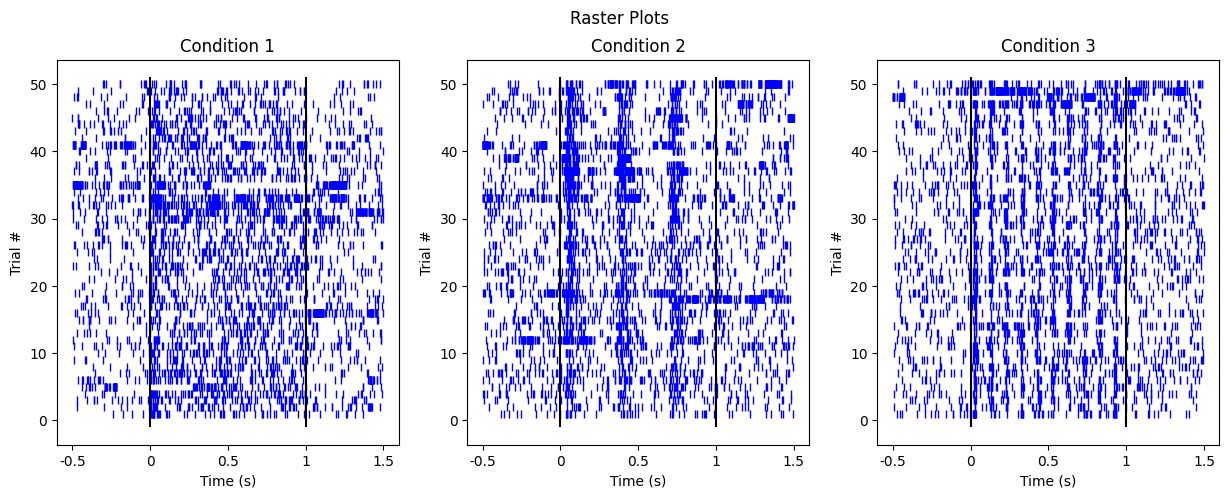

In [76]:
trials_condition_1 = trial_runner(
    filtered_data_condition_1, STIM_TIMES[0], threshold_condition_1
)
trials_condition_2 = trial_runner(
    filtered_data_condition_2, STIM_TIMES[1], threshold_condition_2
)
trials_condition_3 = trial_runner(
    filtered_data_condition_3, STIM_TIMES[2], threshold_condition_3
)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Raster Plots")

create_raster_plot(trials_condition_1, axs[0], 1)
create_raster_plot(trials_condition_2, axs[1], 2)
create_raster_plot(trials_condition_3, axs[2], 3)

In [77]:
""" 
Calculate the firing rate over time for each trial from 0.5 seconds before stimulation starts to 0.5
seconds after stimulation stops. Plot the average firing rate across trials for each of the 3 stimulation
patterns. 

Hint: This data was shown in class. Save your plot to a file named <netid>_part_c.png.
Submit it along with your code (50 pts).
"""

' \nCalculate the firing rate over time for each trial from 0.5 seconds before stimulation starts to 0.5\nseconds after stimulation stops. Plot the average firing rate across trials for each of the 3 stimulation\npatterns. \n\nHint: This data was shown in class. Save your plot to a file named <netid>_part_c.png.\nSubmit it along with your code (50 pts).\n'

In [78]:
WINDOW_SECONDS = 20 * (10**-3)
SAMPLES_PER_WINDOW = int(WINDOW_SECONDS * SAMPLE_FREQUENCY)


def get_firing_rates(trial):

    trial_length = (
        trial["ecog_data_index_window"][1] - trial["ecog_data_index_window"][0]
    )
    # print("trial length: ", trial_length)

    num_windows = int(trial_length / SAMPLES_PER_WINDOW + 2)
    # print("Number of Windows: ", num_windows)

    bucket_start_indices = []
    i = 0

    while i < num_windows:
        bucket_start_indices.append(i * SAMPLES_PER_WINDOW)
        i = i + 1
    # print("bucket_start_indices: ", bucket_start_indices)

    bucket_firing_counts = np.zeros(len(bucket_start_indices))

    for i, start_index in enumerate(bucket_start_indices):

        for firing_index in trial["spike_indices"]:
            if firing_index > start_index and firing_index < bucket_start_indices[i + 1]:
                bucket_firing_counts[i] = bucket_firing_counts[i] + 1

    firing_rates = bucket_firing_counts / WINDOW_SECONDS

    return firing_rates


def get_average_firing_rates(trials):

    firing_rates_by_trial = []

    for trial in trials:
        firing_rates = get_firing_rates(trial)
        firing_rates_by_trial.append(firing_rates)

    # print("firing Rates by Trial: ", firing_rates_by_trial)

    firing_rate_buckets = []

    for trial in firing_rates_by_trial:
        for i, rate in enumerate(trial):
            if len(firing_rate_buckets) <= i:
                firing_rate_buckets.append([])
            firing_rate_buckets[i].append(rate)

    # print("firing Rate Buckets: ", firing_rate_buckets)

    average_firing_rates = []

    for bucket in firing_rate_buckets:
        average_firing_rates.append(np.mean(bucket))

    # print("Average firing Rates: ", average_firing_rates)

    return average_firing_rates


def create_firing_rate_plot(average_firing_rates, axs, condition_number):

    axs.plot(average_firing_rates)

    axs.plot(average_firing_rates)

    ticks = np.array([0, 0.5, 1, 1.5, 2]) / WINDOW_SECONDS
    labels = [-0.5, 0, 0.5, 1, 1.5]

    axs.set_xticks(ticks, labels)

    vlines = np.array([0.5, 1.5]) / WINDOW_SECONDS

    axs.vlines(vlines, -1, np.max(average_firing_rates) + 1, "k")

    axs.set_xlabel("Time (s)")
    axs.set_ylabel("Average firing Rate (Hz)")
    axs.set_title("Condition #" + str(condition_number))

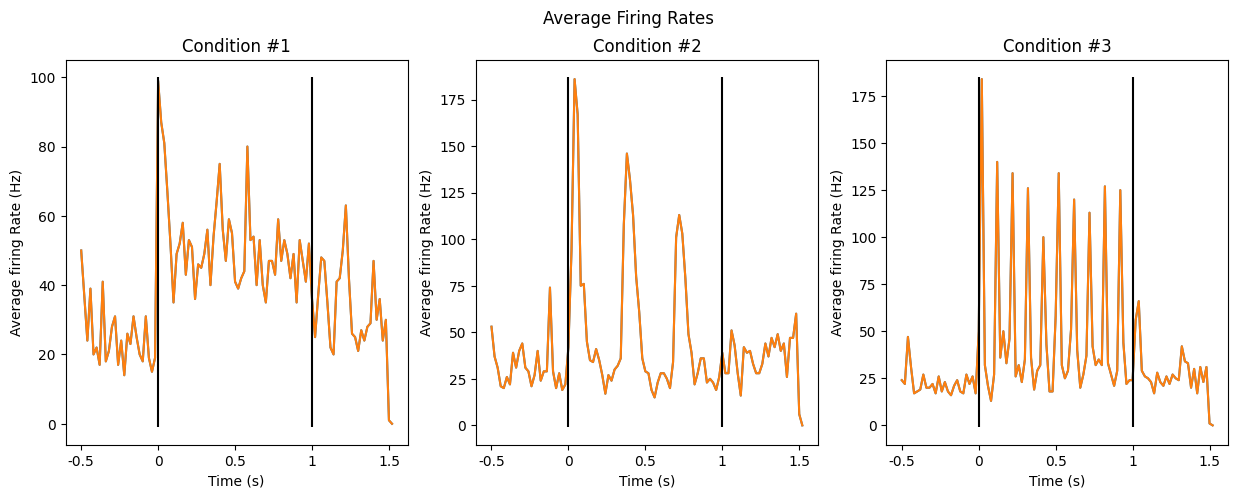

In [79]:
average_firing_rates_condition_1 = get_average_firing_rates(trials_condition_1)
average_firing_rates_condition_2 = get_average_firing_rates(trials_condition_2)
average_firing_rates_condition_3 = get_average_firing_rates(trials_condition_3)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Average Firing Rates")

create_firing_rate_plot(average_firing_rates_condition_1, axs[0], 1)
create_firing_rate_plot(average_firing_rates_condition_2, axs[1], 2)
create_firing_rate_plot(average_firing_rates_condition_3, axs[2], 3)